**Mini-Project: Finding the porosity of a soil sample with 3D images using Machine Learning**
To calculate the porosity of a soil sample using 3D images, images are converted to 2D images in a series of slices with $40*40$ pixels with $1000$ pixels as the height of the sample. The height of the sample is modified on the grounds of Machine Learning to work properly. These 2D images represent the volume of $40*40$ pixels extruding in the third dimension and making slices. The porosity of a soil sample can be calculated using the formula below:

$n=V_{v}/V$                                              (1)

To find the total porosity of the sample, first, the porosity of each slice is calculated and the average porosity of all slices is assumed to be the porosity of the sample. The total volume of a slice can be calculated as below:

$V=200*200*h=1600*h$                                    (2)

h: height of each slice

The void volume of a slice can be calculated by finding the black area in the image and using the formula below:

$V_{v}=black-area*h$                                     (3) 

By replacing (2) and (3) in (1), the porosity can be calculated as below:

$n=black-area/1600$

In the following notebook, first, the porosity for each slice is calculated by finding the black area in each image. Then, Neural Networks is developed to train a model to predict the porosity of a soil sample using 3D images. The accuracy of the model is investigated and a test image is provided to predict the porosity. The Neural Networks model can predict porosity by getting an image as a 2D array of numbers representing the color of each pixel.

Modules are imported into the file.

In [357]:
import pathlib
import numpy as np
from PIL import Image  
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score
from skimage.measure import label, regionprops

The raw file is imported into the file.

In [358]:
filepath = pathlib.Path(r"C:\Users\meysa\OneDrive\Desktop\New folder\Berea_2d25um_grayscale_filtered.raw")

First, the images are determined from the raw file. To find the proper images, $1000*1000$ images are gathered and saved. As mentioned before, $1000$ slices are selected to fulfill the need for Neural Networks.

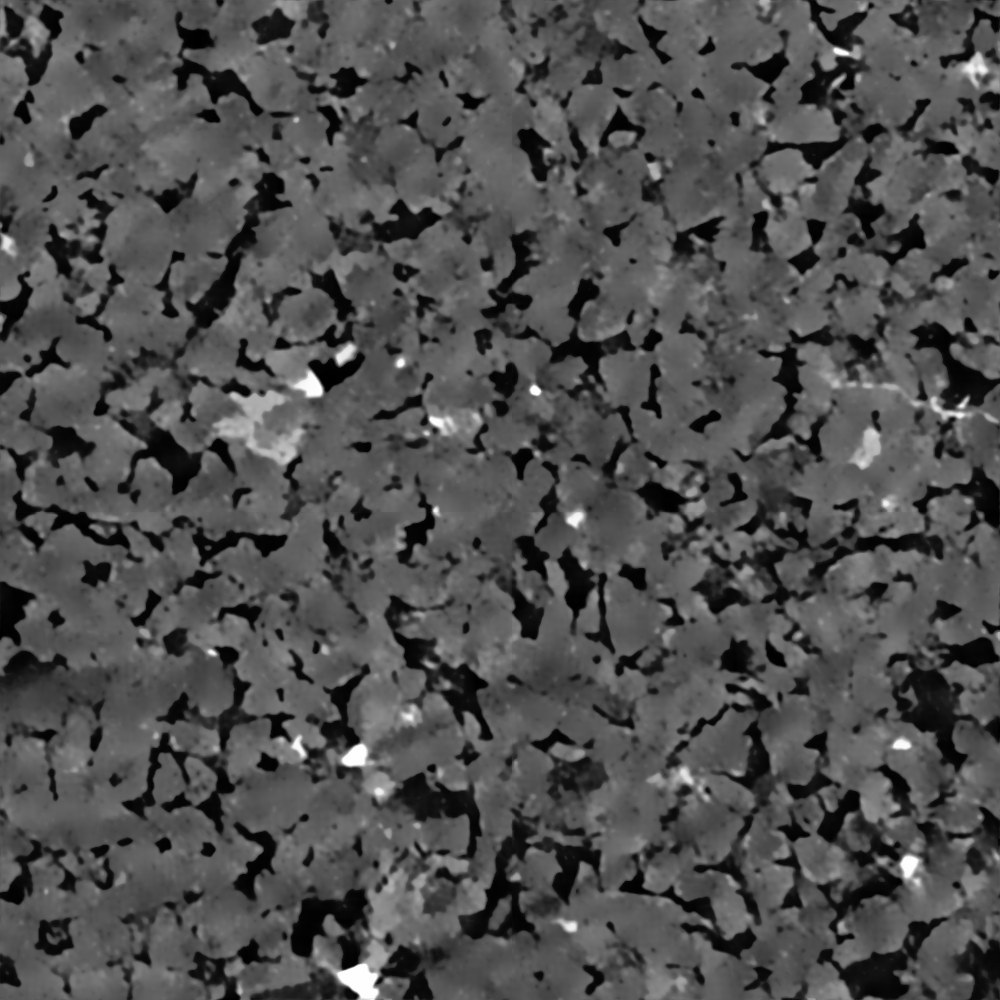

In [359]:
# Set volume parameters  
img_width = 1000
img_height = 1000
num_slices = 1000  # Depth 

# Open file
with filepath.open("rb") as f:
    volume = np.zeros([num_slices, img_height, img_width], dtype=np.uint8)  

    # Read each slice    
    for i in range(num_slices):
        # Read grayscale slice as numpy array
        bytes = f.read(img_width*img_height)        
        slice = np.frombuffer(bytes, dtype=np.uint8).reshape((img_height, img_width))
        
        # Assign to 3D volume
        volume[i] = slice       
    
    # Save slices as images
    for i, slice in enumerate(volume):
        im = Image.fromarray(slice)
        path = os.path.join(r"C:\Users\meysa\OneDrive\Desktop\New folder", f"slice{i}.jpg")
        if i == 0:
            display(im)
        im.save(path)

The previous images are cropped to provide $40*40$ images. 

In [374]:
# Set image paths
original_paths = [os.path.join(r"C:\Users\meysa\OneDrive\Desktop\New folder", f'slice{i}.jpg') for i in range(1000)]  
cropped_paths = [os.path.join(r"C:\Users\meysa\OneDrive\Desktop\New folder", f'i{i}.jpg') for i in range(1000)]

# Crop dimensions
crop_size = 40

count=0
for orig_path, crop_path in zip(original_paths, cropped_paths):

    img = Image.open(orig_path)
    
    # Get width, height
    img_w, img_h = img.size  
    
    # Calculate center coordinate
    center_w, center_h = img_w//2, img_h//2 
    
    # Crop box coords
    left = center_w - crop_size//2     
    right = center_w + crop_size//2
    top = center_h - crop_size//2
    bottom = center_h + crop_size//2
    
    # Crop and save 
    crop_img = img.crop((left, top, right, bottom))
    crop_img.save(crop_path)
    count+=1

The function below is defined to calculate the black area in each image. Then the black area to total area ratio is calculated.

In [361]:
# Corrected function to detect black areas
def calculate_black_ratio(image):
    # Otsu's thresholding
    thresh, bin_img = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Count black pixels
    black_pixels = np.sum(bin_img == 0)

    # Calculate areas 
    black_area = black_pixels
    total_area = image.shape[0]*image.shape[1]

    # Calculate ratio 
    ratio = black_area / total_area

    return ratio

The $40*40$ images are loaded. 

In [362]:
# Load images 
image_paths = [os.path.join(r"C:\Users\meysa\OneDrive\Desktop\New folder", f'i{i}.jpg') for i in range(1000)]  
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

The shadowed images in the data made some mistakes in results. In order to delete corrupted images, those images are separated from the dataset.

In [363]:
black_ratios = []
temp = []
count = 0
for image in images:

    ratio = calculate_black_ratio(image)
    if ratio > 0.4:
        temp.append(count)
    count+=1
    
    black_ratios.append(ratio)

A_b_values = np.array(black_ratios)  
A_r_values = 1 - A_b_values
y = np.array([A_b / (A_b + A_r) for A_b, A_r in zip(A_b_values, A_r_values)])

edited_images = images
edited_y = y
temp.sort(reverse=True)
for i in temp:
    edited_images = np.delete(edited_images, i, 0)
    edited_y = np.delete(edited_y, i, 0)

X = np.concatenate(edited_images, axis=0)  
X = X.reshape(-1, 40*40)

The dataset is separated into three datasets: train, test and validation.

In [365]:
# Split data into training, validation, and testing sets
X = np.stack(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, edited_y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Hidden layers are produced in this step. Since there is a lack of sufficient data to train the model to find porosity from a $40*40$ pixels, numerous layers have been provided.

In [383]:
# Create and train the machine learning model
model = Sequential([
    Dense(10, activation='relu'),  
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1)                     
])

Eventually, the Neural Networks model is fit to the dataset. 

In [384]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
20/20 [==============================] - 1s 9ms/step - loss: 31.7648 - val_loss: 0.1849
Epoch 2/500
20/20 [==============================] - 0s 3ms/step - loss: 0.3170 - val_loss: 0.0557
Epoch 3/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0245
Epoch 4/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0093
Epoch 5/500
20/20 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0090
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0082
Epoch 7/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0082
Epoch 8/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0078
Epoch 9/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0077
Epoch 10/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0077
Epoch 11

The prediction of the model and the real porosity are compared to find the accuracy of the Neural Networks model. Because of lack of data, the parameter $R^2$ is not sufficiently close to $1$.

In [385]:
# Calculate n_sub for each image using the model
n_sub_values = model.predict(X)

# Calculate R2 score
r2 = r2_score(edited_y, n_sub_values)
print("R-squared:", r2)

24/24 [==============================] - 0s 1ms/step
R-squared: 0.6339512813822826


The total porosity of the model is calculated as the average porosity of slices.

In [386]:
# Calculate average n_sub (n_total)
n_total = np.mean(n_sub_values)
print("Average n_sub (n_total):", n_total)

Average n_sub (n_total): 0.253022


A test image is imported to the file to predict the porosity of one slice. The predicted porosity is close to the average porosity calculated by the code.

In [387]:
# Load and prepare test image
i_test = cv2.imread("i_test.jpg", cv2.IMREAD_GRAYSCALE)

# Predict n_sub for test image
n_sub = model.predict(X_test)[0][0]
print(f"Predicted n_sub (n) for i_test: {n_sub:0.3f}")

3/3 [==============================] - 0s 0s/step
Predicted n_sub (n) for i_test: 0.263
